In [67]:
import string
import random
from timeit import default_timer as timer
from time import sleep, process_time
from matplotlib import pyplot as plt
import numpy as np
from sklearn.mixture import BayesianGaussianMixture
import pandas as pd
from scipy.stats import norm

In [2]:
def string_compare(a, b):
    
    i = 0
    
    while i < len(a) and i < len(b):
        
        if a[i] != b[i]:
            return
        
        sleep(0.005)
        
        i += 1

In [3]:
alphabet = string.ascii_uppercase + string.ascii_lowercase + string.digits

In [4]:
def random_string(length):    
    return ''.join(random.choices(alphabet, k=length))

In [5]:
unknown_password = random_string(24)
print(f"Unknown password: {unknown_password}")

Unknown password: wqVd1h2C2GNrMrmBVjJIvUyx


In [6]:
def query(a):
    
    start = process_time()
    string_compare(unknown_password, a)
    end = process_time()

    return end - start

In [55]:
n_queries = 500
deltas = []
    
for character in alphabet:

    for _ in range(n_queries):
    
        guess_password_km1 = ('!' * 24)
        t_km1 = query(guess_password_km1)
        
        guess_password_k = character + ('!' * 23)        
        t_k = query(guess_password_k)
        
        deltas += [t_k - t_km1]        

In [56]:
averages = []

for i in range(len(alphabet)):
    
    averages += [np.mean(deltas[i * n_queries : (i + 1) * n_queries])]

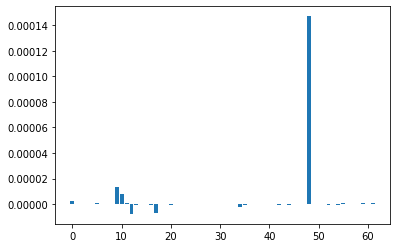

In [57]:
_ = plt.bar(range(0, len(alphabet)), averages)

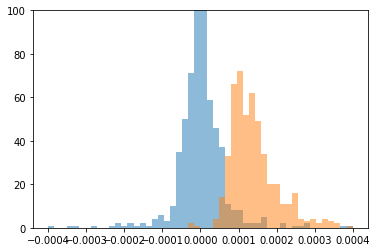

In [58]:
_ = plt.hist(deltas[:48 * n_queries] + deltas[49 * n_queries:], range=(-0.0004, 0.0004), bins=50, alpha=0.5)
_ = plt.hist(deltas[48 * n_queries:49 * n_queries], range=(-0.0004, 0.0004), bins=50, alpha=0.5)
#_ = plt.hist(deltas, range=(-0.0004, 0.0004), bins=50, alpha=0.5)

_ = plt.ylim(0, 100)

In [59]:
np.argmax(averages)

48

In [134]:
gmm = BayesianGaussianMixture(n_components=2, tol=1e-5, max_iter=1000)

In [135]:
gmm.fit(np.array(deltas).reshape(-1, 1))

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
                        degrees_of_freedom_prior=None, init_params='kmeans',
                        max_iter=1000, mean_precision_prior=None,
                        mean_prior=None, n_components=2, n_init=1,
                        random_state=None, reg_covar=1e-06, tol=1e-05,
                        verbose=0, verbose_interval=10, warm_start=False,
                        weight_concentration_prior=None,
                        weight_concentration_prior_type='dirichlet_process')

In [136]:
gmm.weights_

array([9.99956747e-01, 4.32530699e-05])

In [137]:
gmm.means_

array([[2.29427425e-06],
       [3.09093760e-03]])

In [138]:
gmm.covariances_

array([[[1.00175286e-06]],

       [[1.08101987e-05]]])

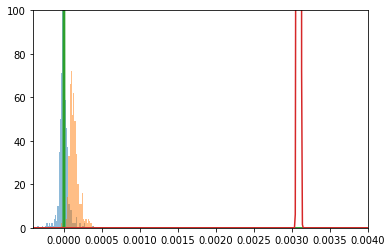

In [139]:
xs = np.linspace(-0.0004, 0.01, 1000)

_ = plt.hist(deltas[:48 * n_queries] + deltas[49 * n_queries:], range=(-0.0004, 0.0004), bins=50, alpha=0.5)
_ = plt.hist(deltas[48 * n_queries:49 * n_queries], range=(-0.0004, 0.0004), bins=50, alpha=0.5)

_ = plt.plot(xs, norm.pdf(xs, gmm.means_[0,0], gmm.covariances_[0,0]))
_ = plt.plot(xs, norm.pdf(xs, gmm.means_[1,0], gmm.covariances_[1,0]))

_ = plt.ylim(0, 100)
_ = plt.xlim(-0.0004, 0.004)

In [116]:
gmm.weights_

array([9.99963615e-01, 3.63853145e-05])